In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, losses

In [22]:
bb_k_fip = pd.read_csv("./bb_fip.csv")
FBv = pd.read_csv("./FBv.csv")
hr = pd.read_csv("./HR.csv")

In [24]:
bb_k = bb_k_fip[['BB', 'K']]
fip = bb_k_fip[['FIP']]
hr = hr[['HR']]
FBv = FBv[['FBv']]

X = pd.concat([bb_k, FBv], axis = 1)
X = pd.concat([X, hr], axis = 1)
y = fip[['FIP']]

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2698 entries, 0 to 2697
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BB      2698 non-null   float64
 1   K       2698 non-null   float64
 2   FBv     2698 non-null   float64
 3   HR      2698 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 84.4 KB


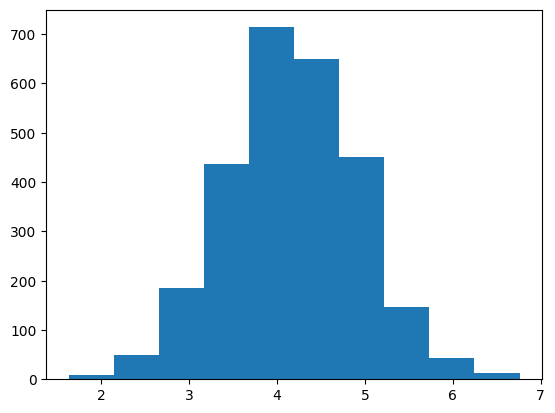

In [26]:
plt.hist(y)
plt.show()

In [27]:
y.describe()

,FIP
count,2698.000000
mean,4.171679
std,0.752043
min,1.630000
25%,3.680000
50%,4.170000
75%,4.690000
max,6.760000


In [28]:
y['fip_cut'] = pd.cut(y.FIP, bins = [0, 3, 4, 5, 7], labels = ["elite", "average", "poor", "awful"])

In [29]:
y

,FIP,fip_cut
0,3.19,average
1,3.19,average
2,3.11,average
3,3.79,average
4,4.33,poor
...,...,...
2693,4.17,poor
2694,3.55,average
2695,3.25,average
2696,3.48,average


In [30]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(y[['fip_cut']])

y_train_res = ohe.transform(y[['fip_cut']])

In [31]:
y_train_ohe = pd.DataFrame(y_train_res.todense(), columns = ohe.get_feature_names_out())

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_train_ohe, test_size = 0.2)

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
X_train.shape

(2158, 4)

In [35]:
x = layers.Input(shape = (X_train.shape[1]))
relu = layers.Dense(64, activation='relu')(x)
dropout = layers.Dropout(0.3)(relu)
relu = layers.Dense(32, activation='relu')(dropout)
dropout = layers.Dropout(0.3)(relu)
relu = layers.Dense(16, activation='relu')(dropout)
y = layers.Dense(4, activation='softmax')(relu)

optimizer = optimizers.Adam(learning_rate=1e-2)
loss = losses.CategoricalCrossentropy()

model = models.Model(x, y)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [36]:
from keras import callbacks
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [37]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test, y_test], verbose=1, callbacks=es)

Epoch 1/100


2023-02-22 10:54:28.666351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 1s 14ms/step - loss: 1.0382 - accuracy: 0.5663 - val_loss: 0.7792 - val_accuracy: 0.6407
Epoch 2/100
 1/68 [..............................] - ETA: 0s - loss: 0.6711 - accuracy: 0.7812

2023-02-22 10:54:29.678742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 1s 11ms/step - loss: 0.7625 - accuracy: 0.6594 - val_loss: 0.6649 - val_accuracy: 0.6833
Epoch 3/100
68/68 [==============================] - 1s 13ms/step - loss: 0.6990 - accuracy: 0.6951 - val_loss: 0.6446 - val_accuracy: 0.6907
Epoch 4/100
68/68 [==============================] - 1s 11ms/step - loss: 0.6797 - accuracy: 0.6969 - val_loss: 0.7004 - val_accuracy: 0.6907
Epoch 5/100
68/68 [==============================] - 1s 11ms/step - loss: 0.6877 - accuracy: 0.6858 - val_loss: 0.6407 - val_accuracy: 0.7019
Epoch 6/100
68/68 [==============================] - 1s 10ms/step - loss: 0.6571 - accuracy: 0.7034 - val_loss: 0.6804 - val_accuracy: 0.6778
Epoch 7/100
68/68 [==============================] - 1s 10ms/step - loss: 0.6480 - accuracy: 0.7122 - val_loss: 0.7730 - val_accuracy: 0.6481
Epoch 8/100
68/68 [==============================] - 1s 10ms/step - loss: 0.6448 - accuracy: 0.7183 - val_loss: 0.6570 - val_accuracy: 0.7056
Epoch 9/100
68/68 

In [38]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier()
modelRF.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
y_train_pred = modelRF.predict(X_train)
y_test_pred = modelRF.predict(X_test)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       761
           1       1.00      1.00      1.00       269
           2       1.00      1.00      1.00       142
           3       1.00      1.00      1.00       986

   micro avg       1.00      1.00      1.00      2158
   macro avg       1.00      1.00      1.00      2158
weighted avg       1.00      1.00      1.00      2158
 samples avg       1.00      1.00      1.00      2158



In [41]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       189
           1       0.60      0.33      0.43        82
           2       0.93      0.54      0.68        24
           3       0.68      0.78      0.72       245

   micro avg       0.71      0.68      0.69       540
   macro avg       0.74      0.59      0.64       540
weighted avg       0.71      0.68      0.68       540
 samples avg       0.68      0.68      0.68       540



/Users/kim-yeong-u/miniforge3/envs/py3_8_13/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
